# Import Libraries

In [19]:
import os
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Load and View Data

In [2]:
# warnings.filterwarnings("ignore")
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# path_train = "/kaggle/input/rossmann-store-sales/train.csv"
# path_test = "/kaggle/input/rossmann-store-sales/test.csv"
# path_store = "/kaggle/input/rossmann-store-sales/store.csv"
path_train = "rossmann-store-sales/train.csv"
path_test = "rossmann-store-sales/test.csv"
path_store = "rossmann-store-sales/store.csv"

store = pd.read_csv(path_store)
test = pd.read_csv(path_test)
train = pd.read_csv(path_train)

print("store shape", store.shape)
print("test shape", test.shape)
print("train shape", train.shape)

print("store duplicates", store.duplicated().sum())
print("test duplicates", test.duplicated().sum())
print("train duplicates", train.duplicated().sum())
print()
print("store columns: ", list(store.columns))
print()
print("test columns: ", list(test.columns))
print()
print("train columns: ", list(train.columns))

train = train.merge(store, how="left", left_on="Store", right_on="Store")
test = test.merge(store, how="left", left_on="Store", right_on="Store")

/tmp/ipykernel_102970/459500512.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(path_train)


store shape (1115, 10)
test shape (41088, 8)
train shape (1017209, 9)
store duplicates 0
test duplicates 0
train duplicates 0

store columns:  ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

test columns:  ['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

train columns:  ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']


In [4]:
print("-"*20+" Train "+"-"*20)
print(train.head(3))
print()
print("-"*20+" Test "+"-"*20)
print(test.head(3))

-------------------- Train --------------------
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1          

In [7]:
def column_handler(df, test_columns, train_columns):
    target = "sales"
    df.columns = [col.lower().strip() for col in df.columns]
    test_columns = set(test_columns)
    train_columns = set(train_columns)
    common_columns = list(test_columns.intersection(train_columns))
    common_columns.append(target)
    return df[common_columns]

In [8]:
train_columns = ['store', 'promo2sinceyear', 'promo2', 'storetype', 'schoolholiday', 'stateholiday',
                 'promo', 'competitiondistance', 'date', 'competitionopensincemonth', 'assortment', 'dayofweek',
                 'promo2sinceweek', 'open', 'competitionopensinceyear', 'promointerval', 'sales']

test_columns = ['store', 'promo2sinceyear', 'promo2', 'storetype', 'schoolholiday', 'stateholiday',
                'promo', 'competitiondistance', 'date', 'competitionopensincemonth', 'assortment', 'dayofweek',
                'promo2sinceweek', 'open', 'competitionopensinceyear', 'promointerval']
df = column_handler(train.copy(), train_columns, test_columns)
test.columns = [col.lower().strip() for col in test.columns]
test = test[df.drop("sales", axis = 1).columns]
test.head(2)

,date,store,dayofweek,stateholiday,schoolholiday,promo2,storetype,promo2sinceweek,competitionopensincemonth,promointerval,promo2sinceyear,promo,competitiondistance,open,competitionopensinceyear,assortment
0,2015-09-17,1,4,0,0,0,c,NaN,9.0,NaN,NaN,1,1270.0,1.0,2008.0,a
1,2015-09-17,3,4,0,0,1,a,14.0,12.0,"Jan,Apr,Jul,Oct",2011.0,1,14130.0,1.0,2006.0,a


# EDA

In [9]:
class Eda:
    def __init__(self):
        pass
    def get_specific_col(self, df:pd.DataFrame, main_type=None, sub_type=None):
        if main_type == "numerical":
            numerical_columns = list(df.describe(include="number").columns)
            if not sub_type:
                return numerical_columns
            binary_columns = [col for col in numerical_columns if df[col].nunique()==2]
            discrete_columns = [col for col in numerical_columns if df[col].nunique()<32]
            if sub_type == "binary":
                return binary_columns
            elif sub_type == "discrete":
                return discrete_columns
            elif sub_type == "continous":
                continous_columns = [col for col in numerical_columns if col not in binary_columns + discrete_columns]
                return continous_columns
            elif sub_type == "temporal":
                temporal_columns = ["date", "dayofweek", "competitionopensincemonth",
                                    "competitionopensinceyear", "promo2sinceweek", "promo2sinceyear"]
                return temporal_columns
        elif main_type == "categorical":
            categorical_columns = list(df.describe(exclude="number").columns)
            return categorical_columns
        else:
            return []

eda = Eda()

In [10]:
# Function to get top ten sum
df['date'] = df["date"].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').date()) # Convert Date column from string to datetime format
df['year'] = df['date'].apply(lambda x: x.year) # Fetching year from Date
top10storesWithHighestSales = df.groupby(['store'])['sales'].sum().sort_values(ascending=False).head(10)
meanSalesForStateHoliday = df.groupby(['stateholiday'])['sales'].sum().sort_values(ascending=False)
meanSalesForSchoolHoliday = df.groupby(['schoolholiday'])['sales'].sum().sort_values(ascending=False)
meanSalesForDayOfWeek = df.groupby(['dayofweek'])['sales'].sum().sort_values(ascending=False)
meanSalesForPromo = df.groupby(['promo'])['sales'].sum().sort_values(ascending=False)

In [11]:
print("Data distribution of open closed:")
print(f"{df['open'].value_counts()}")

Data distribution of open closed:
open
1    844392
0    172817
Name: count, dtype: int64


In [12]:
print("Sum of the sales when shops are closed :",df[df["open"]==0]["sales"].sum())
print("Sum of the sales when shops are opened :",df[df["open"]==1]["sales"].sum())

Sum of the sales when shops are closed : 0
Sum of the sales when shops are opened : 5873180623


In [13]:
top10storesWithHighestSales.reset_index(name='sum_sales')

,store,sum_sales
0,262,19516842
1,817,17057867
2,562,16927322
3,1114,16202585
4,251,14896870
5,513,14252406
6,788,14082141
7,733,14067158
8,383,13489879
9,756,12911782


In [14]:
meanSalesForStateHoliday.reset_index(name='MeanSale')

,stateholiday,MeanSale
0,0,5113659442
1,0,751505326
2,a,5890305
3,b,1433744
4,c,691806


In [15]:
meanSalesForSchoolHoliday.reset_index(name='MeanSale')

,schoolholiday,MeanSale
0,0,4696260531
1,1,1176920092


In [16]:
meanSalesForPromo.reset_index(name='MeanSale')

,promo,MeanSale
0,1,3101206286
1,0,2771974337


In [17]:
meanSalesForDayOfWeek.reset_index(name='MeanSale')

,dayofweek,MeanSale
0,1,1130203012
1,2,1020411930
2,5,980555941
3,3,954962863
4,4,911177709
5,6,846317735
6,7,29551433


# DataVisualization

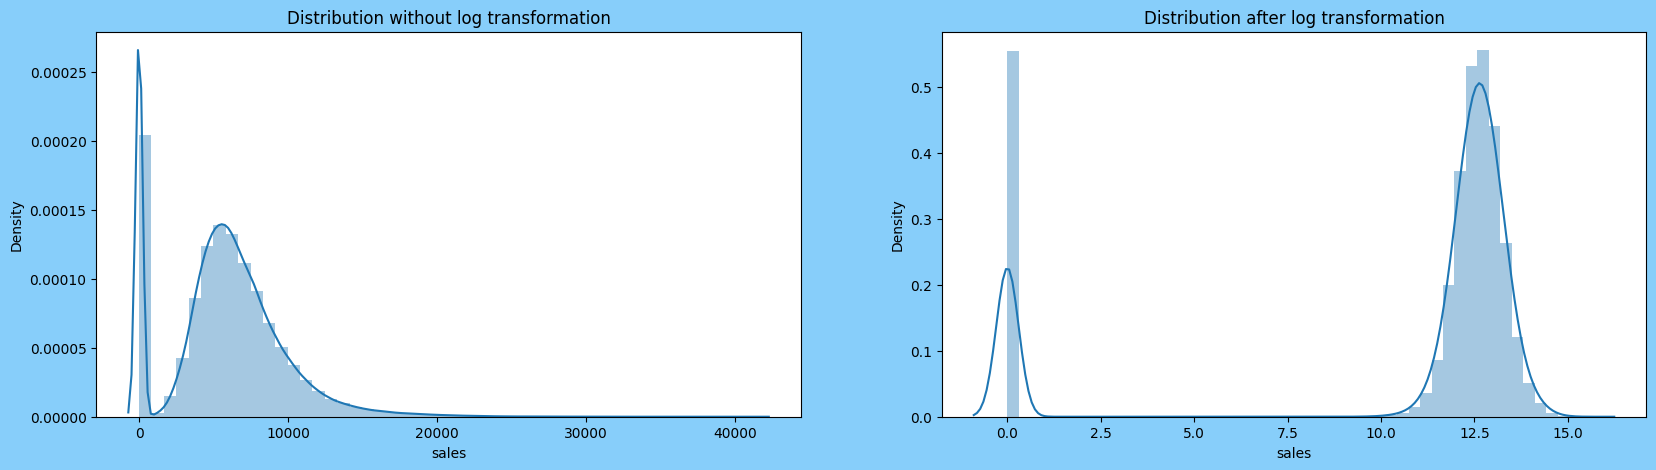

In [20]:
# Chart - 1 visualization code
facecolor = 'lightskyblue'
fig, axes = plt.subplots(ncols=2, nrows=1, facecolor=facecolor, figsize=(20,5))
sns.distplot(df['sales'], ax=axes[0]) # Without log-transformation
axes[0].set_title('Distribution without log transformation')
sns.distplot(np.log2(df['sales']+1), ax=axes[1]) # After log-transformation
axes[1].set_title('Distribution after log transformation')
plt.show()

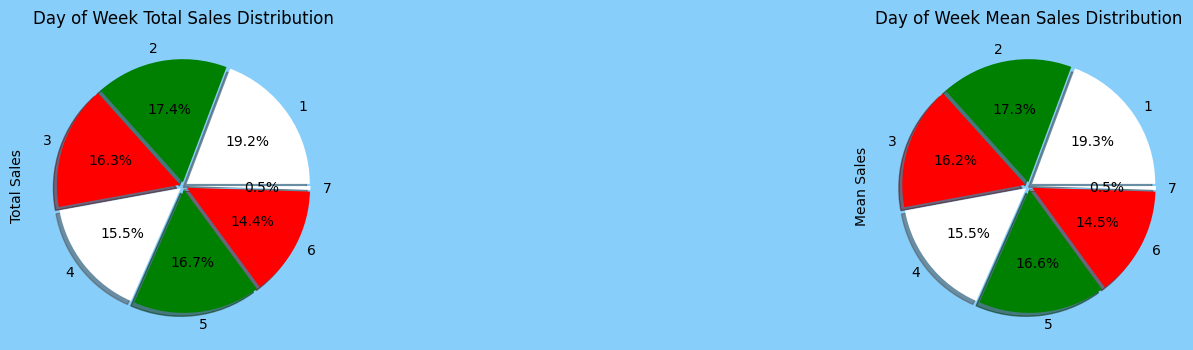

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor=facecolor, figsize=(20, 4))
df.groupby(['dayofweek'])['sales'].sum().plot.pie(ax=axes[0],shadow =True,
                                                  explode=[0.03,0.03,0.03,0.03,0.03,0.03,0.03],
                                                  autopct='%0.1f%%',colors={'red','white','green'})
df.groupby(['dayofweek'])['sales'].mean().plot.pie(ax=axes[1],shadow =True,
                                                   explode=[0.03,0.03,0.03,0.03,0.03,0.03,0.03],
                                                   autopct='%0.1f%%',colors={'red','white','green'})
axes[0].set_title('Day of Week Total Sales Distribution')
axes[0].set_ylabel("Total Sales")

axes[1].set_title('Day of Week Mean Sales Distribution')
axes[1].set_ylabel("Mean Sales")
plt.show()

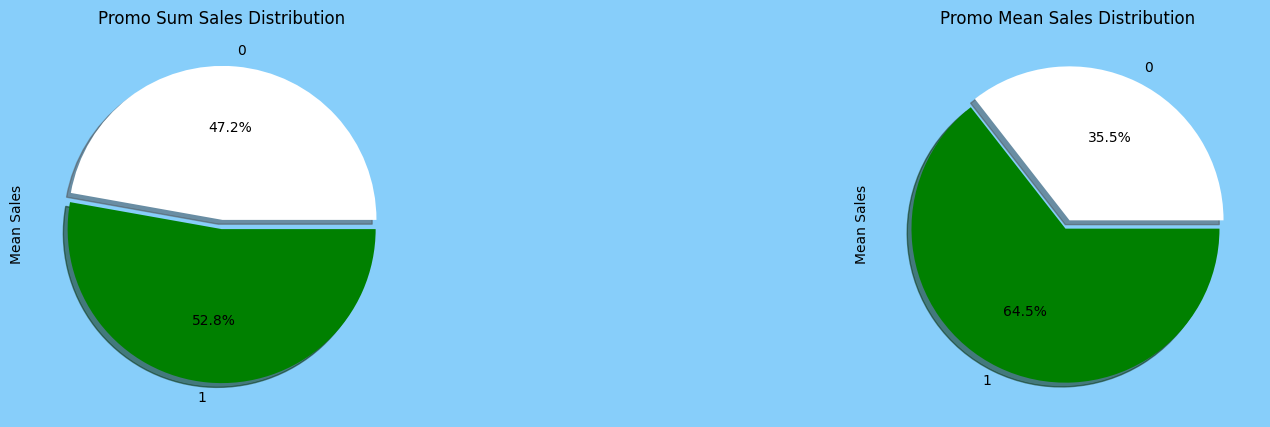

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor=facecolor, figsize=(20, 5))
df.groupby(['promo'])['sales'].sum().plot.pie(ax=axes[0],
                                              shadow =True,explode=[0.03,0.03],
                                              autopct='%0.1f%%',colors={'red','white','green'})
df.groupby(['promo'])['sales'].mean().plot.pie(ax=axes[1],
                                               shadow =True,explode=[0.03,0.03],
                                               autopct='%0.1f%%',colors={'red','white','green'})

axes[0].set_title('Promo Sum Sales Distribution')
axes[0].set_ylabel("Mean Sales")

axes[1].set_title('Promo Mean Sales Distribution')
axes[1].set_ylabel("Mean Sales")
plt.show()

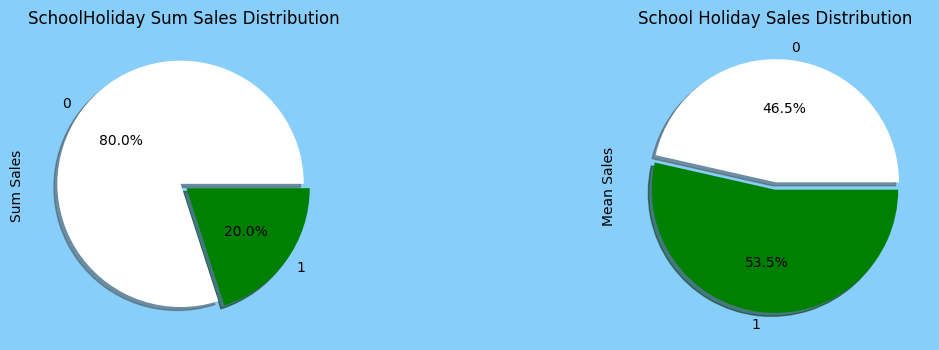

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor=facecolor, figsize=(14, 4))
df.groupby(['schoolholiday'])['sales'].sum().plot.pie(ax=axes[0],shadow =True,
                                                      explode=[0.03,0.03],
                                                      autopct='%0.1f%%',
                                                      colors={'red','white','green'})
df.groupby(['schoolholiday'])['sales'].mean().plot.pie(ax=axes[1],shadow =True,
                                                       explode=[0.03,0.03],
                                                       autopct='%0.1f%%',
                                                       colors={'red','white','green'})
axes[0].set_title('SchoolHoliday Sum Sales Distribution')
axes[0].set_ylabel("Sum Sales")

axes[1].set_title('School Holiday Sales Distribution')
axes[1].set_ylabel("Mean Sales")
plt.show()

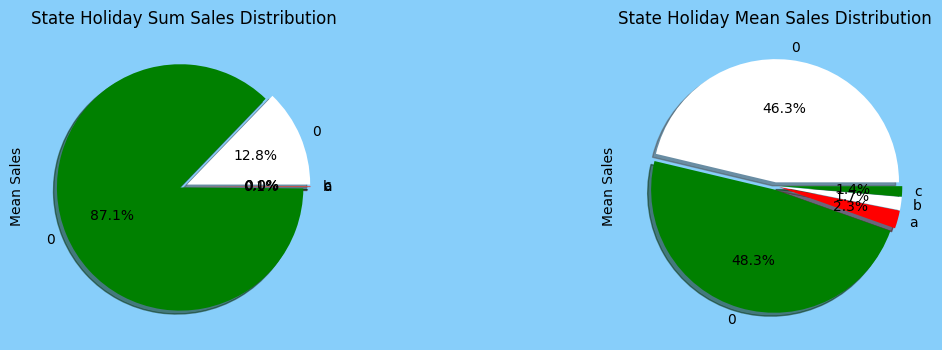

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor=facecolor, figsize=(14, 4))
df.groupby(['stateholiday'])['sales'].sum().plot.pie(ax=axes[0],shadow =True,explode=[.03,.03,.03,.03,.03], autopct='%0.1f%%',colors={'red','white','green'})
df.groupby(['stateholiday'])['sales'].mean().plot.pie(ax=axes[1],shadow =True,explode=[.03,.03,.03,.03,.03], autopct='%0.1f%%',colors={'red','white','green'})
axes[0].set_title('State Holiday Sum Sales Distribution')
axes[0].set_ylabel("Mean Sales")

axes[1].set_title('State Holiday Mean Sales Distribution')
axes[1].set_ylabel("Mean Sales")
plt.show()

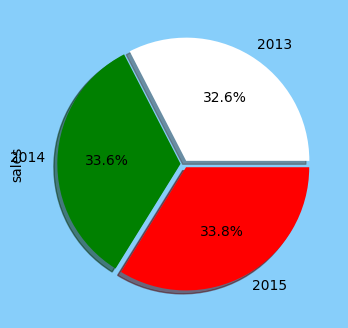

In [25]:
plt.figure(facecolor=facecolor, figsize=(4,4))
df.groupby(['year'])['sales'].mean().plot.pie(shadow =True,explode=[0.03,0.03,.03], autopct='%0.1f%%',colors={'red','white','green'})
plt.show()

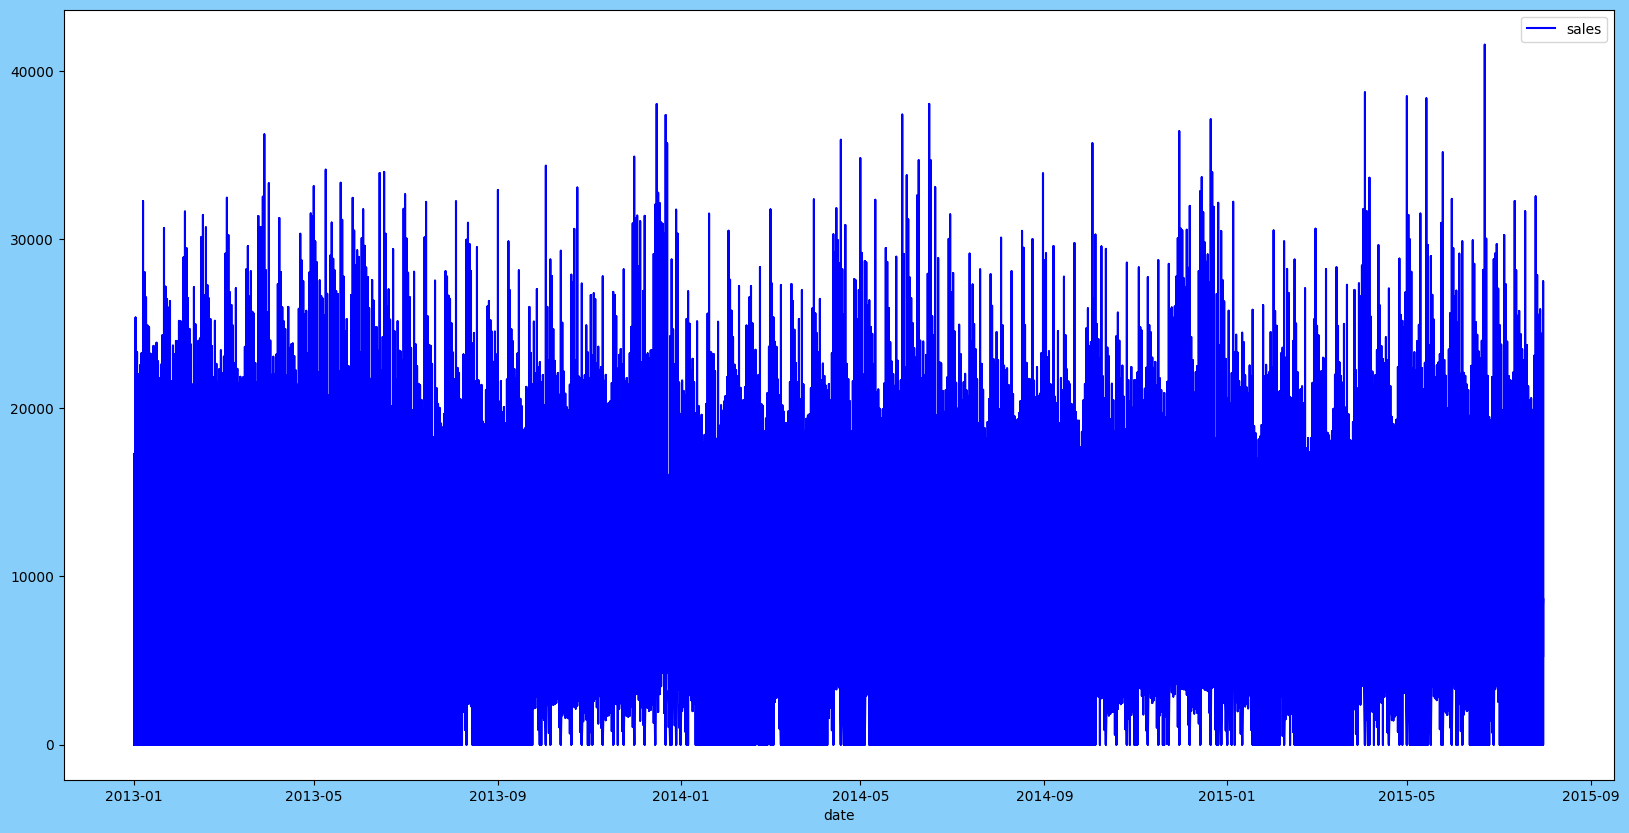

In [27]:
plt.figure(figsize=(20,10), facecolor=facecolor)
plt.plot(df['date'],df['sales'],label='sales', color='blue')
plt.xlabel('date')
plt.legend()
plt.show()

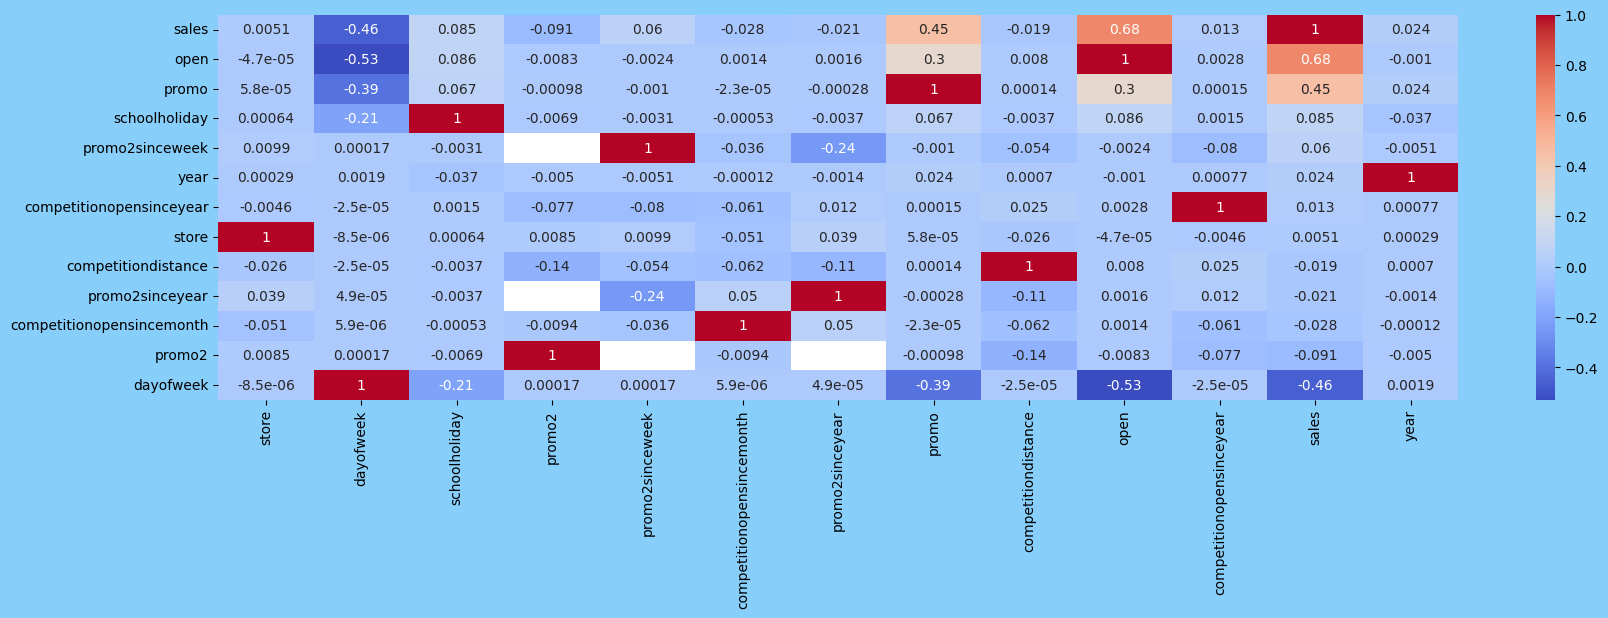

In [28]:
plt.figure(figsize=(20,5), facecolor=facecolor)
num_cols = df.describe(include="number").columns
# num_cols = ['Sales', 'Customers','SchoolHoliday', 'DayOfWeek', 'Promo']
corr = df[num_cols].corr()
sns.heatmap(corr.sort_values(by="sales", ascending=False), cmap='coolwarm', annot=True)
plt.show()

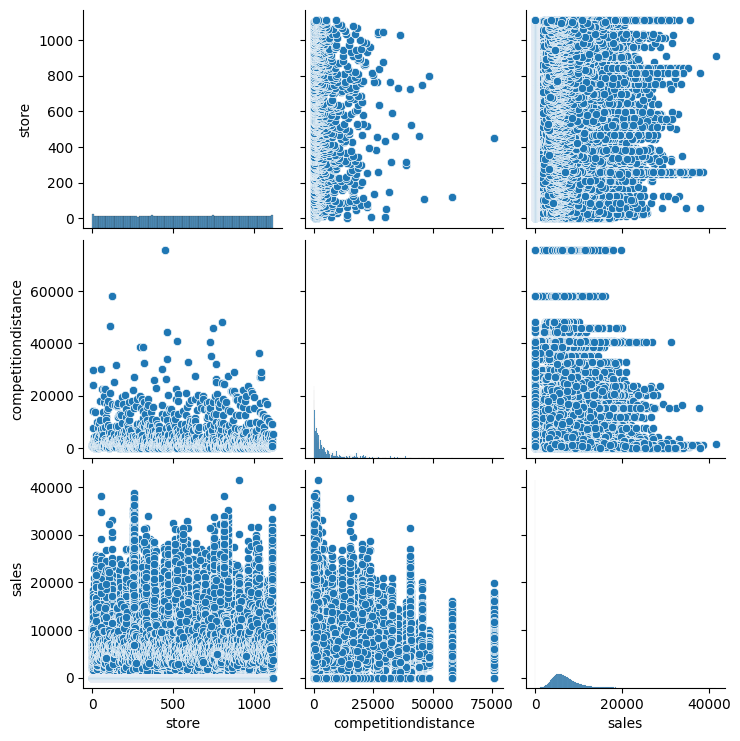

In [29]:
continous_columns = eda.get_specific_col(df.copy(), main_type= "numerical", sub_type= "continous")
sns.pairplot(df[continous_columns])
plt.show()

# Feature Engineering

In [110]:
# drop dayofweek create new feature isSunday for day 7 only    
class FeatureEngineering(Eda):
    def __init__(self):
        super().__init__()
        pass

    def __is_present(self, df:pd.DataFrame):
        features = ["competitionopensincemonth", "competitionopensinceyear",
                    "promo2sinceweek", "promo2sinceyear", "promointerval"]
        for col in features:
            if col in df.columns:
                df[f"is_{col}"] = df[col].isna().astype(int)
            else:
                print(f"column {col} not found to create isPresent")
        return df

    def __handle_null(self, df:pd.DataFrame):
        features = ["competitionopensincemonth", "competitionopensinceyear",
                    "promo2sinceweek", "promo2sinceyear", "promointerval"]
        df["competitiondistance"] = df["competitiondistance"].fillna(df["competitiondistance"].mean())
        for col in features:
            if col in df.columns:
                df[col] = df[col].fillna(0)
            else:
                print(f"column {col} not found to handle null")
        return df

    def __date_transformation(self, df:pd.DataFrame):
        """
        Extract day, month, year from date and delete date column.
        """
        if "date" in df.columns:
            try:
                df["date"] = df["date"].astype(str).apply(lambda x:datetime.strptime(x, "%Y-%m-%d"))
                df["year"] = df["date"].dt.year
                df["month"] = df["date"].dt.month
                df["day"] = df["date"].dt.day
                df = df.drop("date", axis = 1)
                df["month_name"] = df["month"].apply(lambda x: calendar.month_abbr[x])
                print("date transformed successfully")
            except Exception as e:
                print(e)
        else:
            print("date column not found")
        return df

    def __handle_categorical(self, df:pd.DataFrame, encoder=None, fit=True):
        """
        OneHotEncode categorical columns.
        """
        categorical_columns = self.get_specific_col(df, main_type="categorical")
        print("categorical columns:", categorical_columns)
        df["stateholiday"] = df["stateholiday"].astype(str)
        if fit:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            encoder.fit(df[categorical_columns])
        encoded_array = encoder.transform(df[categorical_columns])
        df_encoded = pd.DataFrame(data=encoded_array, columns= encoder.get_feature_names_out(), index= df.index)
        df = pd.concat([df.drop(categorical_columns, axis = 1), df_encoded], axis=1)
        print("categorical encoding successfully done")
        return df, encoder
        
    def calculate_vif(self, df:pd.DataFrame):
        """
        Check variance inflation factor if training a linear model
        """
        X = df.drop("sales", axis = 1)
        vif_data = pd.DataFrame()
        vif_data["features"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data
        
    def __data_transformation(self, df: pd.DataFrame, fit=True):
        """
        Transform the continous columns to log1p.
        """
        if fit:
            df["sales"] = np.log1p(df["sales"])
        df["competitiondistance"]= np.log1p(df["competitiondistance"])
        return df

    def data_split(self, df, train_size=0.8):
        """
        Do train test split before scaling to avoid data leakage.
        """
        df = df.sort_values(by= ["year", "month", "day"])
        train_proportion = train_size
        train_size = int(train_size * df.shape[0])
        train = df[:train_size]
        test = df[train_size:]
        return train, test

    def __data_scaling(self, df:pd.DataFrame,
                       scaler_x=None,
                       scaler_y=None,
                       fit=True):
        x = ["competitiondistance"]
        if fit:
            scaler_x = StandardScaler()
            # scaler_y = StandardScaler()
            scaler_x.fit(df[x].values)
            # scaler_y.fit(df[["sales"]].values)
            # df["sales"]= scaler_y.transform(df[["sales"]].values)
        df[x]= scaler_x.transform(df[x].values)
        return df, scaler_x, scaler_y

    def inverse_target(self, target, scaler_y):
        target = scaler_y.inverse_transform(target)
        target = target.flatten()
        target = np.expm1(target)
        return target
        

    def feature_engineering(self, df:pd.DataFrame,
                            encoder=None,
                            scaler_x=None,
                            scaler_y=None,
                            fit=True):
        """
        Feature Engineering Pipeline.
        """
        print("Initial Shape :",df.shape)
        df.columns = [col.lower().strip() for col in df.columns]
        df = df[(df["open"]==1) & (df["sales"]>0)]
        df = df.drop("open", axis = 1)
        df = self.__is_present(df)
        df = self.__handle_null(df)
        df = self.__date_transformation(df)
        df["promointerval"] = df["promointerval"].fillna("no_promo").replace(0, "no_promo")
        df["is_promo_month"] = df.apply(lambda row: 1 if row["month_name"] in str(row["promointerval"]).split(",") else 0, axis = 1)
        df = df.drop(["promointerval", "month_name"], axis = 1)
        df, encoder = self.__handle_categorical(df, encoder=encoder)
        df = self.__data_transformation(df, fit=fit)
        train, test = self.data_split(df, train_size=0.8)
        train, scaler_x, scaler_y = self.__data_scaling(df=train, scaler_x = scaler_x, scaler_y = scaler_y)
        test, scaler_x, scaler_y = self.__data_scaling(df=test, scaler_x = scaler_x, scaler_y = scaler_y, fit=False)
        print("Final Shape:", df.shape)
        return train, test, encoder, scaler_x, scaler_y

feature_engineering = FeatureEngineering()
df_processed_train, df_processed_test, encoder, scaler_x, scaler_y = feature_engineering.feature_engineering(df.copy())

Initial Shape : (1017209, 18)
date transformed successfully
categorical columns: ['stateholiday', 'storetype', 'assortment']
categorical encoding successfully done
Final Shape: (844338, 31)


In [58]:
X_train = df_processed_train.drop("sales", axis=1)
X_test = df_processed_test.drop("sales", axis=1)

y_train = df_processed_train["sales"]
y_test = df_processed_test["sales"]

In [106]:
# model = XGBRegressor()
# model.fit(X_train, y_train)

model = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.5,
    objective='reg:squarederror',
    early_stopping_rounds=100
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=None, num_parallel_tree=None, ...)

In [109]:
# pred = model.predict(X_train)
def predict(model, X, y, seen = False):
    pred = model.predict(X)
    pred = scaler_y.inverse_transform(pred.reshape(-1,1)).flatten()
    pred = np.expm1(pred)
    if seen:
        y = scaler_y.inverse_transform(y).flatten()
    y = np.expm1(y)
    r2 = r2_score(y, pred)
    # print(f"pred: {pred[:10]}")
    # print(f"actual: {y[:10]}")
    print(r2)

print("TRAIN")
predict(model, X_train, y_train.values.reshape(-1,1), seen=True)
print("TEST")
predict(model, X_test, y_test.values.reshape(-1,1), seen=False)

TRAIN
0.04103847245103154
TEST
0.009135772401408171
